In [1]:
# !pip install interpret
# !pip install --user xgboost
# !pip install pytorch-tabnet
# !pip install anchor-exp

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from interpret import preserve, show
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

random_state=42

In [3]:
dataset_folder = 'dataset/explain_te-master/selected/'

file = 'diaretino.csv'
class_names = [0, 1]
_class = 'dr'

In [4]:
df = pd.read_csv(dataset_folder + file)
df.replace(('yes', 'no'), (1, 0), inplace=True)
df.head()

qa  ps  ma0.5  ma0.6  ma0.7  ma0.8  ma0.9  ma1.0      ex0.5      ex0.6  \
0   1   1     22     22     22     19     18     14  49.895756  17.775994   
1   1   1     24     24     22     18     16     13  57.709936  23.799994   
2   1   1     62     60     59     54     47     33  55.831441  27.993933   
3   1   1     55     53     53     50     43     31  40.467228  18.445954   
4   1   1     44     44     44     41     39     27  18.026254   8.570709   

       ex0.7     ex0.8     ex0.9     ex1.0      exm1      exm2    eucmac  \
0   5.270920  0.771761  0.018632  0.006864  0.003923  0.003923  0.486903   
1   3.325423  0.234185  0.003903  0.003903  0.003903  0.003903  0.520908   
2  12.687485  4.852282  1.393889  0.373252  0.041817  0.007744  0.530904   
3   9.118901  3.079428  0.840261  0.272434  0.007653  0.001531  0.483284   
4   0.410381  0.000000  0.000000  0.000000  0.000000  0.000000  0.475935   

     diaopt  amfm  dr  
0  0.100025     1   0  
1  0.144414     0   0  
2  0.128548     0   1  
3  0.114790     0   0  
4  0.123572     0   1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   qa      1151 non-null   int64  
 1   ps      1151 non-null   int64  
 2   ma0.5   1151 non-null   int64  
 3   ma0.6   1151 non-null   int64  
 4   ma0.7   1151 non-null   int64  
 5   ma0.8   1151 non-null   int64  
 6   ma0.9   1151 non-null   int64  
 7   ma1.0   1151 non-null   int64  
 8   ex0.5   1151 non-null   float64
 9   ex0.6   1151 non-null   float64
 10  ex0.7   1151 non-null   float64
 11  ex0.8   1151 non-null   float64
 12  ex0.9   1151 non-null   float64
 13  ex1.0   1151 non-null   float64
 14  exm1    1151 non-null   float64
 15  exm2    1151 non-null   float64
 16  eucmac  1151 non-null   float64
 17  diaopt  1151 non-null   float64
 18  amfm    1151 non-null   int64  
 19  dr      1151 non-null   int64  
dtypes: float64(10), int64(10)
memory usage: 180.0 KB


In [6]:
X, y = df.drop(columns=[_class]), df[_class]

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random_state)

In [8]:
x_test.shape

(346, 19)

In [9]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805 entries, 834 to 1126
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   qa      805 non-null    int64  
 1   ps      805 non-null    int64  
 2   ma0.5   805 non-null    int64  
 3   ma0.6   805 non-null    int64  
 4   ma0.7   805 non-null    int64  
 5   ma0.8   805 non-null    int64  
 6   ma0.9   805 non-null    int64  
 7   ma1.0   805 non-null    int64  
 8   ex0.5   805 non-null    float64
 9   ex0.6   805 non-null    float64
 10  ex0.7   805 non-null    float64
 11  ex0.8   805 non-null    float64
 12  ex0.9   805 non-null    float64
 13  ex1.0   805 non-null    float64
 14  exm1    805 non-null    float64
 15  exm2    805 non-null    float64
 16  eucmac  805 non-null    float64
 17  diaopt  805 non-null    float64
 18  amfm    805 non-null    int64  
dtypes: float64(10), int64(9)
memory usage: 125.8 KB


# ML Model

In [10]:
import sklearn.metrics
import pandas as pd
import time
import numpy as np

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from interpret.glassbox import ExplainableBoostingClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

In [12]:
random_state=42

In [13]:
x_train

qa  ps  ma0.5  ma0.6  ma0.7  ma0.8  ma0.9  ma1.0       ex0.5      ex0.6  \
834    1   1     85     73     70     62     59     37   43.873596  17.321847   
29     1   1    103     89     83     71     60     38   11.025085   3.762343   
745    1   1     12     11     11     11     10      8   73.975723  39.190608   
165    1   1     19     19     19     18     15      9   13.115054   5.845388   
248    1   1     58     57     55     50     43     34   31.499303  16.223873   
...   ..  ..    ...    ...    ...    ...    ...    ...         ...        ...   
1044   1   1     18     18     18     17     13     10   22.320425  10.157700   
1095   1   1     34     34     34     34     33     24  136.285159  25.909910   
1130   1   1     37     36     33     24     18     10   37.686807   4.978201   
860    1   1     11      7      6      6      6      5   31.073428  14.277795   
1126   1   1      4      4      4      4      4      3  118.036826  21.578380   

          ex0.7     ex0.8     ex0.9     ex1.0      exm1      exm2    eucmac  \
834    4.708070  1.229496  0.119951  0.015783  0.014205  0.012626  0.548025   
29     0.015592  0.010914  0.003118  0.003118  0.001559  0.001559  0.488566   
745    6.678279  0.779589  0.121811  0.014211  0.000000  0.000000  0.475377   
165    0.154330  0.050435  0.000000  0.000000  0.000000  0.000000  0.484477   
248    7.405699  0.924929  0.163038  0.083087  0.026650  0.010974  0.519667   
...         ...       ...       ...       ...       ...       ...       ...   
1044   0.657133  0.044193  0.007686  0.003843  0.000000  0.000000  0.570065   
1095  15.509432  5.114110  0.307383  0.048480  0.000000  0.000000  0.523087   
1130   1.180336  0.184896  0.024986  0.007996  0.000000  0.000000  0.535271   
860    1.746907  0.010051  0.000000  0.000000  0.000000  0.000000  0.531741   
1126   7.407548  0.725415  0.003959  0.003959  0.003959  0.003959  0.508743   

        diaopt  amfm  
834   0.107324     0  
29    0.134091     0  
745   0.117750     0  
165   0.109948     0  
248   0.125414     0  
...        ...   ...  
1044  0.090308     1  
1095  0.129967     1  
1130  0.093947     0  
860   0.133682     0  
1126  0.105893     1  

[805 rows x 19 columns]

In [14]:
def classify_report(clfs, dataset):
    x_train, y_train, x_test, y_test = dataset
    data = []
    for clf, name, no_df in clfs:
        if no_df:
            x_tr, x_te = x_train, x_test
        else:
            x_tr, x_te = x_train.values,  x_test.values
        clf.fit(x_tr, y_train)
        pred = clf.predict(x_te)
        f1, acc = sklearn.metrics.f1_score(y_test, pred, average='binary'), sklearn.metrics.accuracy_score(y_test, pred)
        data.append([name, f1, acc])
    df = pd.DataFrame(data, columns = ['Name', 'F1', 'Acc.'])
    df = df.sort_values(by=['F1'])
    return df

In [15]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)
gbc = GradientBoostingClassifier(random_state=random_state)
_xgb = xgb.XGBClassifier(random_state=random_state)
ebm = ExplainableBoostingClassifier(random_state=random_state)
tbn = TabNetClassifier(verbose=0, seed=random_state)

clfs = [(rf, 'rf', True), (gbc, 'gbc', True), (_xgb, 'xgb', True), (ebm, 'ebm', True), (tbn, 'tbn', False)]
# clfs = [(rf, 'rf', True), (ebm, 'ebm', True), (tbn, 'tbn', False)]
dataset = x_train, y_train, x_test, y_test
classify_report(clfs, dataset)

Name        F1      Acc.
0   rf  0.681948  0.679191
4  tbn  0.701887  0.543353
3  ebm  0.706849  0.690751
2  xgb  0.707521  0.696532
1  gbc  0.727273  0.713873

# XAI

In [16]:
# selected_model = _xgb
# For fairness of comparisions we used RF
selected_model = rf

In [17]:
class_names = ['NO','YES']
feature_names = x_train.columns.to_list()
# local = lime, shap, anchor, tabnet, ebm
# global = pfi, tabnet, ebm, shap
# methods = pfi, tabnet, ebm, shap, lime, anchor
# remaining = pdp, eli5, ice, adawhip, break down

## Noisy test

In [18]:
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

x_test_noisy = add_noise(x_test)
display(x_test_noisy)

qa        ps      ma0.5      ma0.6      ma0.7      ma0.8  \
174   1.004722 -0.011909  13.008888  13.005252  12.996210  12.009089   
752   1.010657  0.985935  56.982117  55.988986  54.000530  49.003246   
467   0.986971  1.016347  60.013841  59.002984  57.011495  54.992133   
240   1.000195  1.009776  48.028924  47.992032  47.998722  47.995752   
667   0.989654 -0.005132  26.998762  26.989461  26.991102  25.005288   
...        ...       ...        ...        ...        ...        ...   
931   0.992459  1.012980  17.020109  17.010583  16.995032  14.007038   
1054  1.008064  1.003933  16.994091  16.989922  16.001614  13.993676   
961   0.994742  1.011149  55.009250  54.005601  52.997940  52.993645   
617   1.006776  0.006834  62.006975  62.003280  61.002320  55.011524   
714   0.997235  0.991403  29.994653  29.994537  29.002466  26.985018   

          ma0.9      ma1.0       ex0.5       ex0.6      ex0.7      ex0.8  \
174   11.021311   6.005632   30.993442   14.293865   0.995148   0.048158   
752   46.987215  34.001460   61.401707   29.779030   6.188762   0.430800   
467   48.996678  33.010119   50.253911   35.396845  13.552983   4.287072   
240   40.995846  30.000416   34.025268   13.429021   6.028178   1.525966   
667   23.002854  18.997558   10.711830    4.561809   1.386684   0.085190   
...         ...        ...         ...         ...        ...        ...   
931   12.005759   8.999301   68.668928   23.969278   8.873197   1.356321   
1054  10.013149  10.006862  236.207637  107.807961  65.604673  14.582079   
961   52.001387  45.989577   42.817420   22.444038   4.270225   0.491774   
617   52.012755  44.996817   43.407604   28.458487  11.761904   2.084317   
714   25.000769  19.997011   22.727779    5.925481   1.168422   0.058643   

         ex0.9     ex1.0      exm1      exm2    eucmac    diaopt      amfm  
174   0.014343 -0.006721 -0.004062 -0.006575  0.540085  0.150634  0.008683  
752   0.006176 -0.006130  0.007255 -0.003123  0.556752  0.116216  0.002533  
467   1.952636  0.381490  0.051382  0.001071  0.524562  0.136707 -0.004466  
240   0.324675  0.001343 -0.019707 -0.015324  0.533188  0.092212  0.007786  
667   0.004855  0.015908  0.005221 -0.003090  0.514994  0.094066  0.989130  
...        ...       ...       ...       ...       ...       ...       ...  
931   0.140743  0.023906  0.005690 -0.007055  0.499751  0.117401  0.991051  
1054  0.092245  0.015188  0.005795 -0.002891  0.494818  0.105975  0.997591  
961   0.015192  0.019560 -0.002609 -0.009639  0.532159  0.083404 -0.005587  
617   0.180521 -0.005420  0.003766  0.010382  0.475276  0.103040 -0.000761  
714   0.014405  0.006133  0.009016  0.006923  0.561769  0.105820 -0.003637  

[346 rows x 19 columns]

## Local

In [19]:
import lime
from lime import lime_tabular
exp_lime=lime_tabular.LimeTabularExplainer(np.array(x_train),feature_names=x_train.columns,class_names=['NO','YES'],mode='classification')

import shap
shap.plots.initjs()

exp_shap = shap.TreeExplainer(selected_model)

from anchor import anchor_tabular

exp_anchor = anchor_tabular.AnchorTabularExplainer(
    class_names,
    feature_names,
    x_train.values[:,:],
    {})

def get_tbn_local_graph(exp_tn_mat, idx, feature_names):
    m = exp_tn_mat[idx]>0
    ax = pd.Series(exp_tn_mat[idx][m], index=np.array(feature_names)[m]).sort_values(ascending=True).plot.barh()
    ax.set_title("TabNet Feature Importance")
    ax.figure.tight_layout()
    plt.show()

def show_outputs(dataset, _id):
    exp_lime.explain_instance(dataset.iloc[_id,:], selected_model.predict_proba).show_in_notebook(show_all=True)
    shap.plots.waterfall(exp_shap(dataset.iloc[_id:_id+1])[0,:,_prediction], max_display=10)
    preserve(ebm.explain_local(dataset.iloc[_id:_id+1], y_test.iloc[_id:_id+1], name='EBM'), 0)
    get_tbn_local_graph(tbn.explain(dataset.iloc[_id:_id+1].values)[0], 0, feature_names)
    
    exp = exp_anchor.explain_instance(dataset.iloc[_id, :].values, selected_model.predict, threshold=0.99)
    print('  >> Anchor: %s' % (' AND '.join(exp.names())))

In [20]:
def show_data_using_ids(ids_to_explain_list):
    print('Original')
    display(x_test.iloc[ids_to_explain_list])
    print('Noisy')
    display(x_test_noisy.iloc[ids_to_explain_list])
    print('Predictions')
    display(y_test.iloc[ids_to_explain_list])

In [21]:
ids_to_explain_list = [9, 10]

Original


qa  ps  ma0.5  ma0.6  ma0.7  ma0.8  ma0.9  ma1.0       ex0.5      ex0.6  \
328   1   1     44     44     44     44     42     29   25.281979  12.051879   
692   1   1     47     44     41     39     34     24  137.877736  24.437388   

         ex0.7    ex0.8     ex0.9     ex1.0      exm1  exm2    eucmac  \
328   1.637867  0.18539  0.000000  0.000000  0.000000   0.0  0.500516   
692  10.652664  2.66342  0.257193  0.130121  0.001017   0.0  0.487769   

       diaopt  amfm  
328  0.144022     0  
692  0.112840     1

Noisy


qa        ps      ma0.5      ma0.6      ma0.7      ma0.8  \
328  1.004411  1.001482  43.989862  44.003899  43.999729  44.001134   
692  1.019186  0.979602  46.985695  44.022693  40.999733  39.000723   

         ma0.9      ma1.0       ex0.5      ex0.6      ex0.7     ex0.8  \
328  42.013486  29.014922   25.271492  12.041819   1.637126  0.188412   
692  34.017150  23.988129  137.891867  24.434848  10.626660  2.659963   

        ex0.9     ex1.0      exm1      exm2    eucmac    diaopt      amfm  
328 -0.015641 -0.010548 -0.000317 -0.002905  0.528865  0.135991 -0.027568  
692  0.255892  0.132472  0.009307  0.009789  0.502108  0.113364  1.012803

Predictions


328    0
692    1
Name: dr, dtype: int64

ID 9 Prediction:  0
> Original


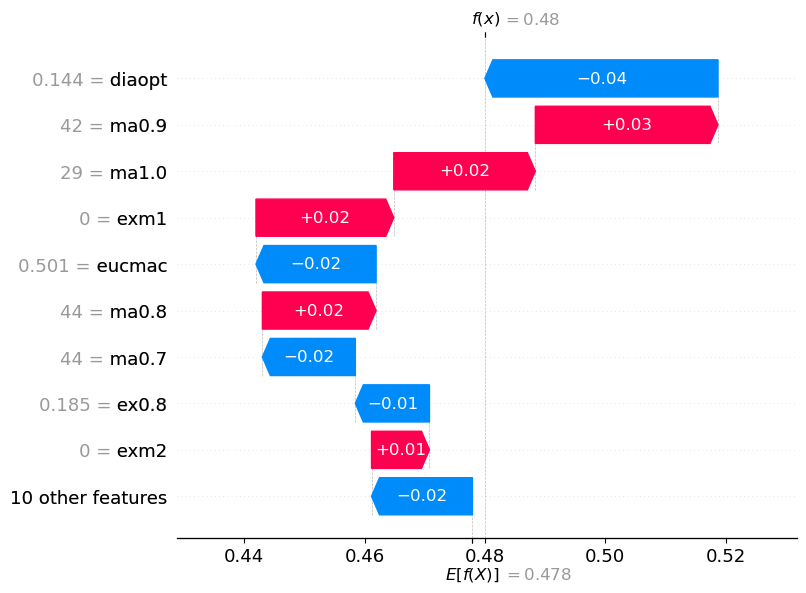

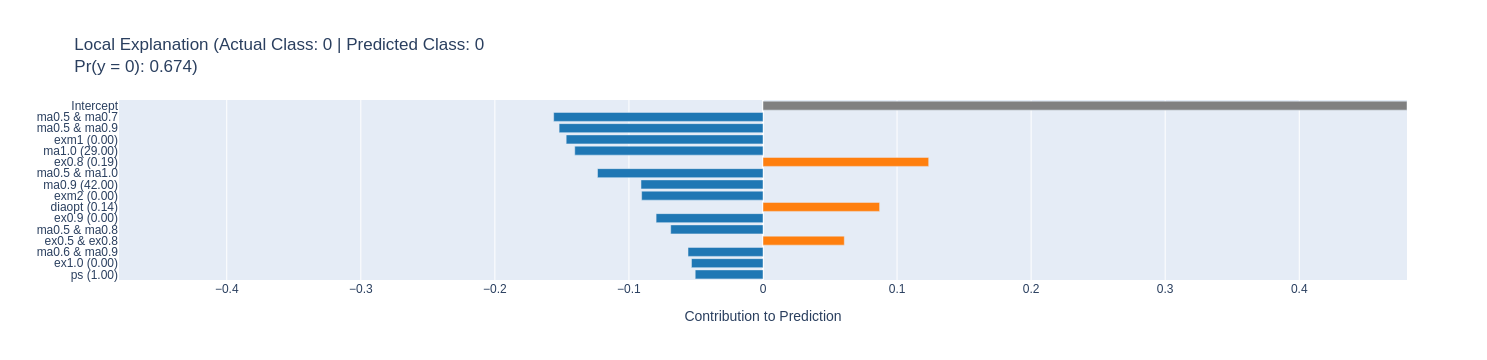

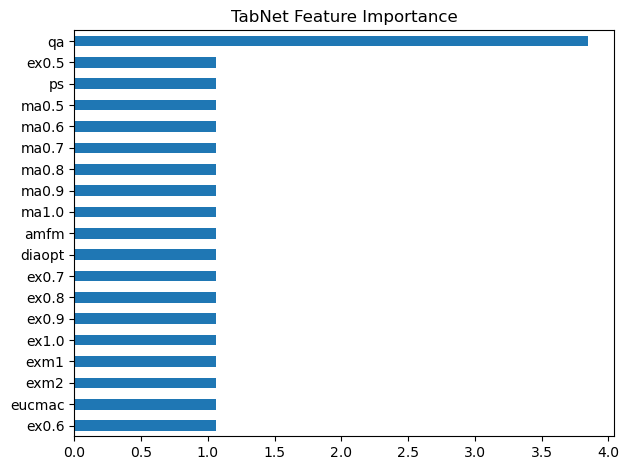

  >> Anchor: ma0.5 > 35.00 AND ex0.6 <= 16.83 AND eucmac <= 0.50 AND diaopt > 0.12 AND ma0.9 <= 43.00 AND 0.08 < ex0.8 <= 0.47 AND ex0.9 <= 0.02 AND ex0.5 > 22.03 AND exm1 <= 0.00 AND ma1.0 <= 32.00 AND ex0.7 > 1.22 AND ex1.0 <= 0.00 AND qa <= 1.00 AND amfm <= 1.00 AND ps <= 1.00
> Noisy


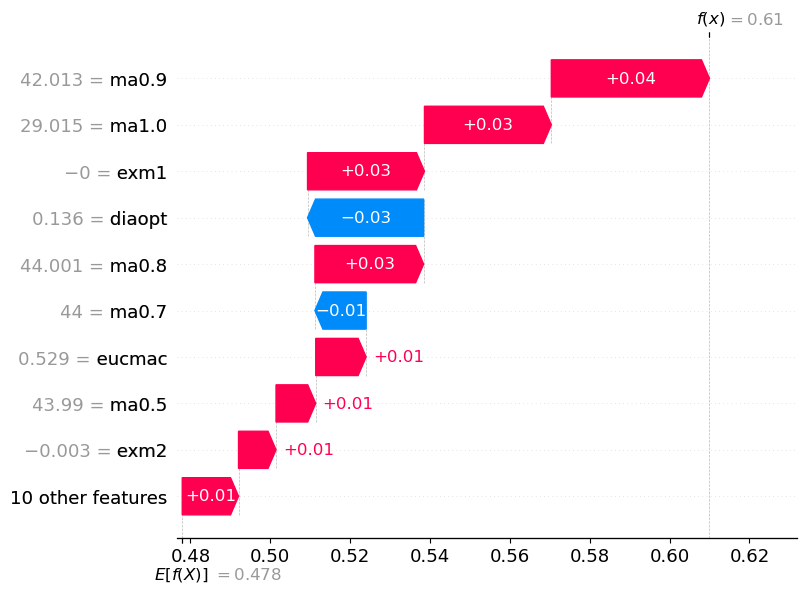

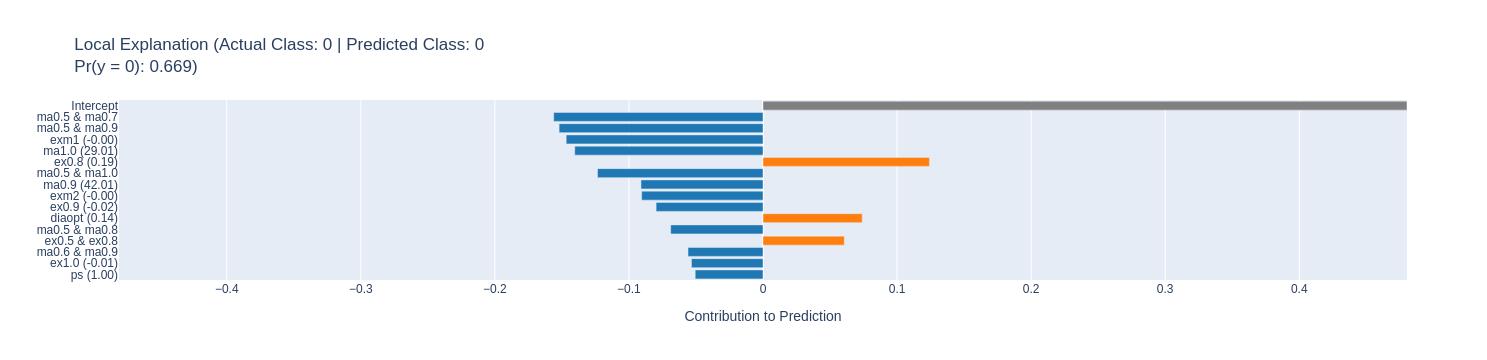

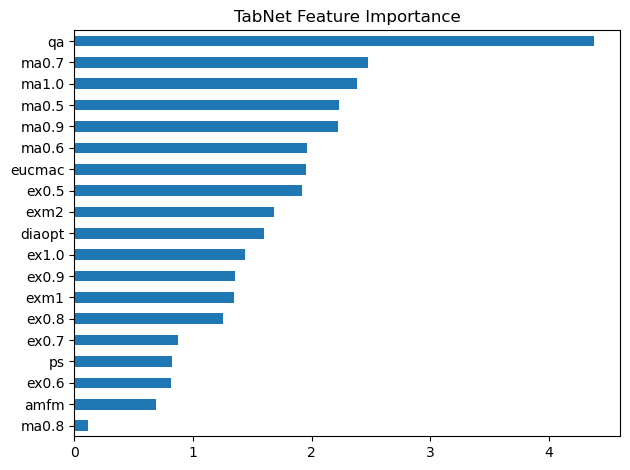

  >> Anchor: ma0.5 <= 55.00 AND ex1.0 <= 0.00 AND 1.22 < ex0.7 <= 4.41 AND 0.08 < ex0.8 <= 0.47 AND diaopt > 0.12 AND 7.70 < ex0.6 <= 16.83 AND exm1 <= 0.00 AND ex0.9 <= 0.18 AND amfm <= 0.00 AND exm2 <= 0.00 AND 22.03 < ex0.5 <= 88.45 AND ma1.0 > 17.00 AND eucmac > 0.52 AND ma0.9 > 24.00 AND ma0.7 > 15.00 AND ma0.6 <= 52.00
ID 10 Prediction:  1
> Original


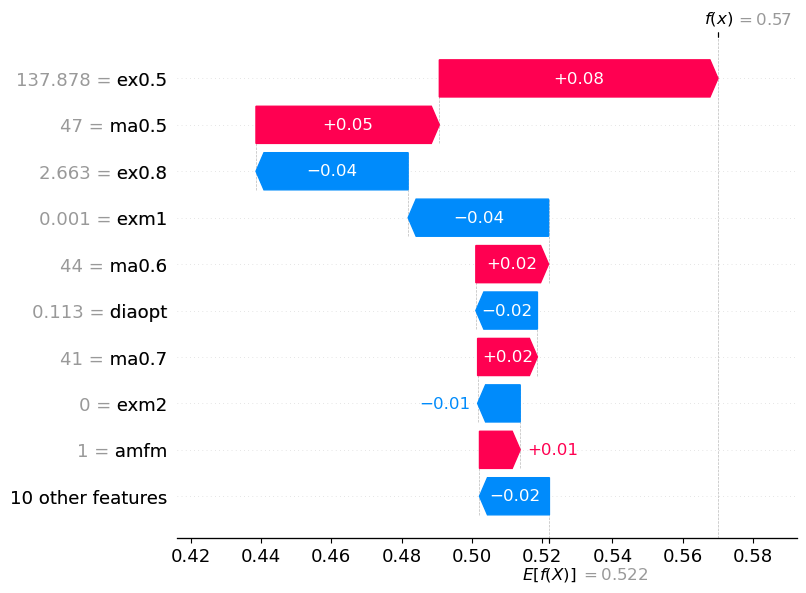

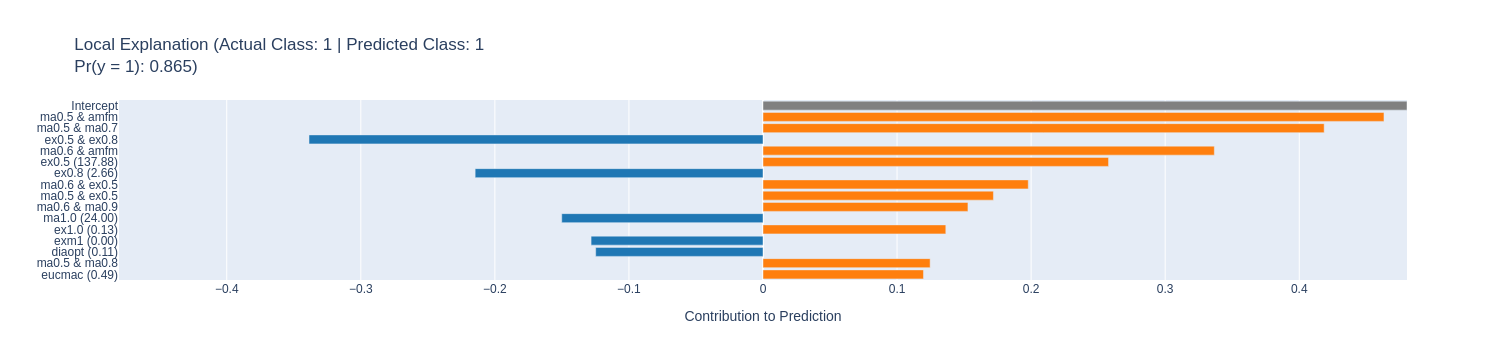

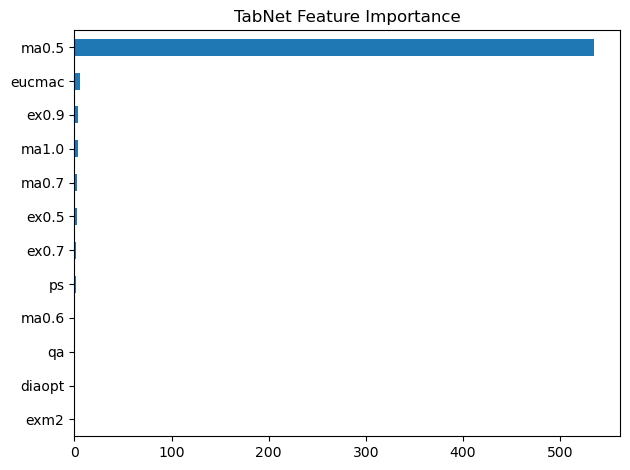

  >> Anchor: ma0.5 > 35.00 AND exm1 > 0.00 AND ma0.6 > 34.00 AND amfm > 0.00
> Noisy


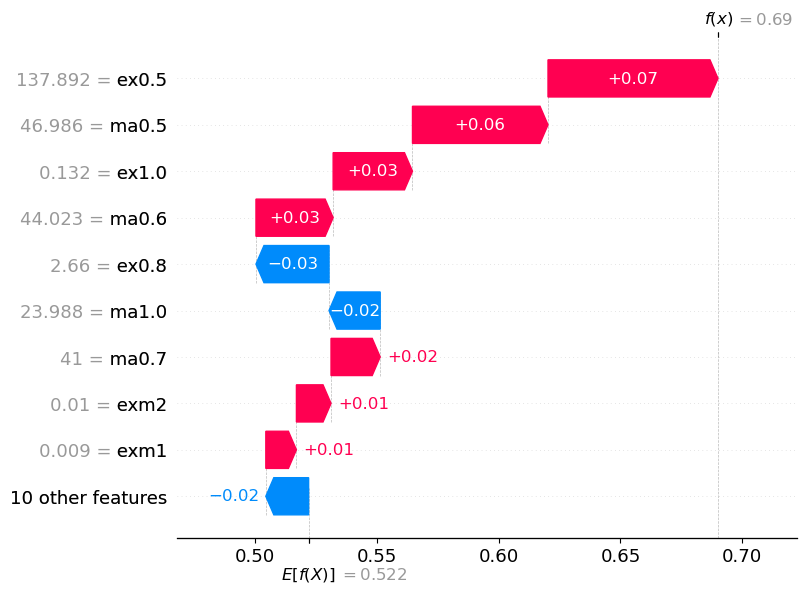

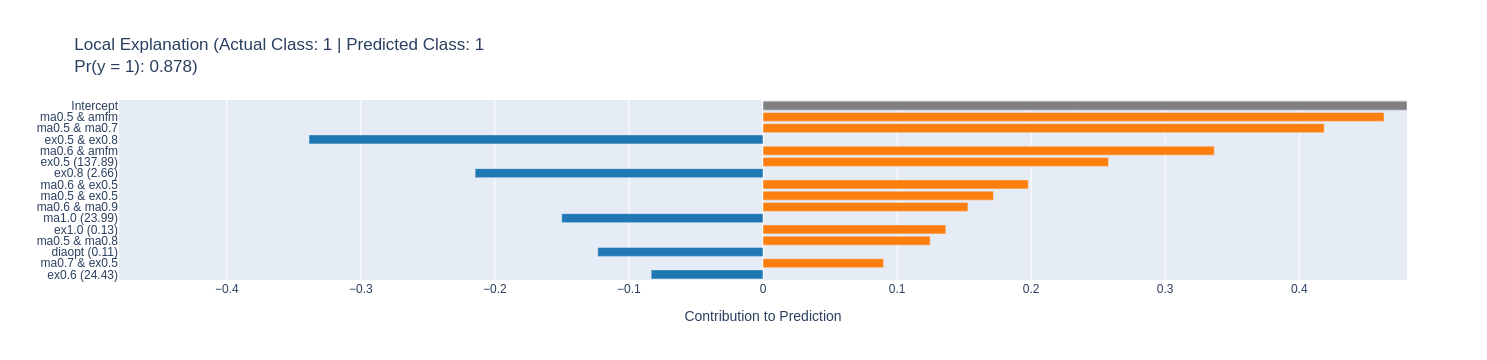

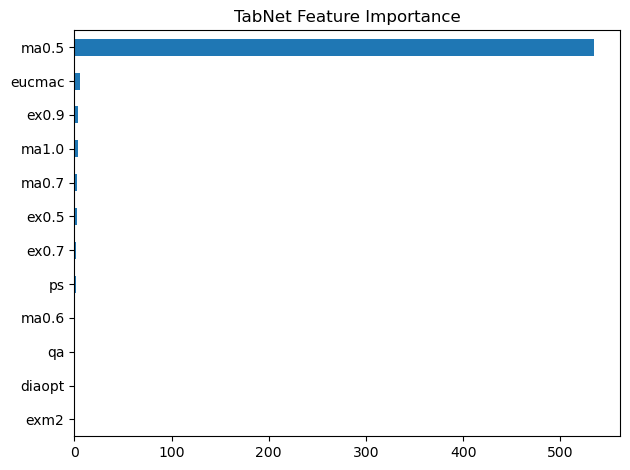

  >> Anchor: ma0.5 > 35.00 AND exm1 > 0.00 AND ex0.5 > 88.45 AND ma0.6 > 34.00 AND ex1.0 > 0.03 AND amfm > 0.00


In [22]:
np.random.seed(random_state)
show_data_using_ids(ids_to_explain_list)
for _id in ids_to_explain_list:
    _prediction = y_test.iloc[_id]
    print('ID', _id,  'Prediction: ', _prediction)

    # Original explanation cases
    # Noisy explanation to compare how the rule (features in the rule) changes due to insertion of Noise
    for msg, dataset in [('Original', x_test), ('Noisy', x_test_noisy)]:
        print('>', msg)
        show_outputs(dataset, _id)

## Global

### PMI

Elapsed time to compute the importances: 0.494 seconds


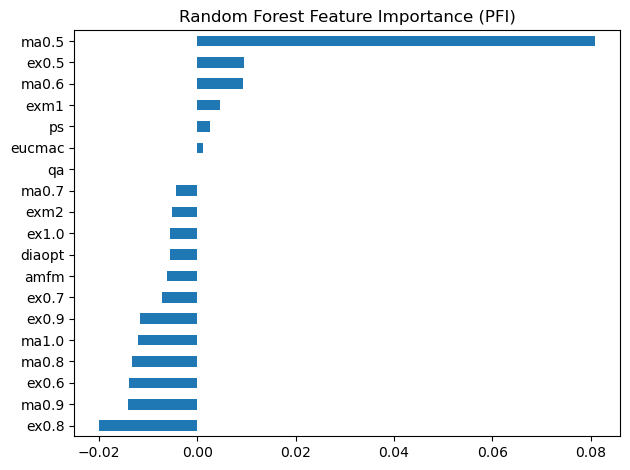

In [23]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    selected_model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

selected_model_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=True)

ax = selected_model_importances.plot.barh()
ax.set_title("Random Forest Feature Importance (PFI)")
ax.figure.tight_layout()

### TABNET

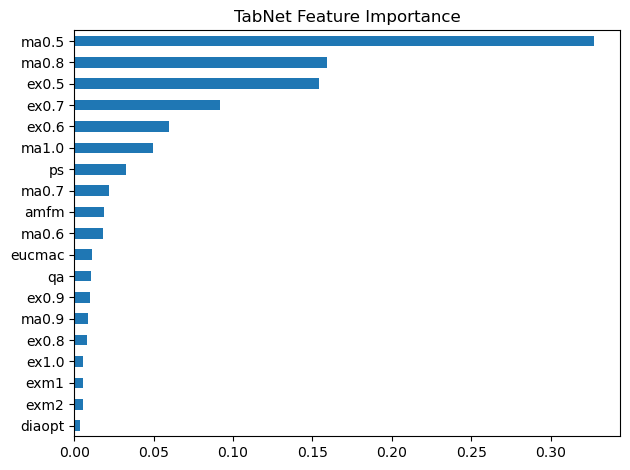

In [24]:
ax = pd.Series(tbn.feature_importances_, index=feature_names).sort_values(ascending=True).plot.barh()
ax.set_title("TabNet Feature Importance")
ax.figure.tight_layout()

### EBM

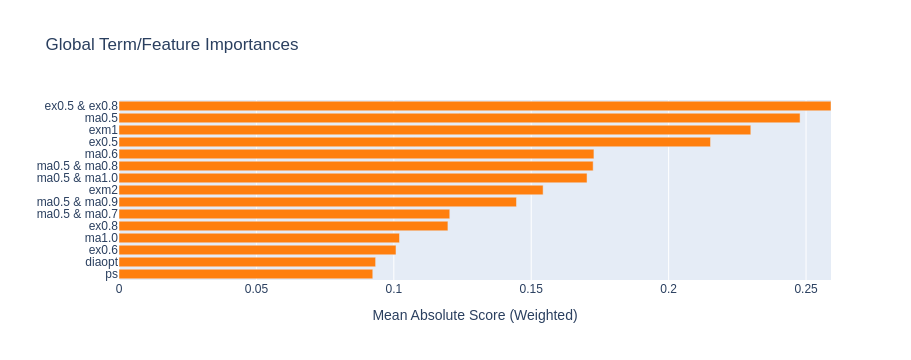

In [25]:
ebm_global = ebm.explain_global()
# show(ebm_global)

# Replace show with the preserve.

# ebm_global = ebm.explain_global(name='EBM')
# show(ebm_global)

# preserve(ebm_global, file_name='output/global-graph.html')
preserve(ebm_global)

### SHAP

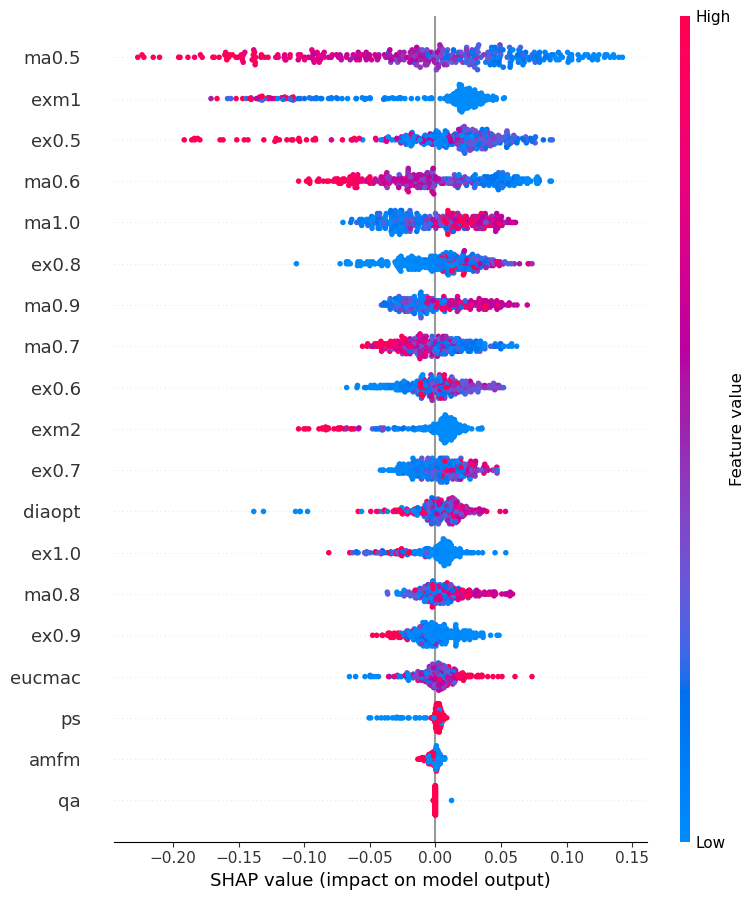

In [26]:
shap_values = exp_shap.shap_values(x_test)
shap.summary_plot(shap_values[:,:,0], x_test)
# shap.summary_plot(shap_values[:,:,0], X_test)

In [27]:
# f.savefig("summary_plot_CS.png", bbox_inches='tight', dpi=600)